In [3]:
import json, os
import numpy as np
import matplotlib.pyplot as plt
from legged_gym import LEGGED_GYM_ROOT_DIR
import seaborn as sns
import pandas as pd
from tqdm import tqdm

In [4]:
def plot_error_lineplots(list_infos, xlabel="Freq", ylabel="Power", names=["Metal"]):
  combined_df = []
  for j, list_info in tqdm(enumerate(list_infos)):
    sizes = [len(sample) for sample in list_info]
    cutting_th = min(sizes)

    new_df = pd.DataFrame()
    subdf_n_average = []
    for yf in list_info:
      xf = np.arange(cutting_th)*0.005*4
      xf, yf = xf[:cutting_th], yf[:cutting_th]
      data = {xlabel: xf,
              ylabel: yf}
      sub_df = pd.DataFrame(data)
      subdf_n_average.append(sub_df)
    new_df = pd.concat(subdf_n_average)
    new_df["Speed"] = names[j]
    combined_df.append(new_df)
  combined_df = pd.concat(combined_df)
  #Plot
  sns.set(style="whitegrid")
  sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
  sns.lineplot(x=xlabel, y=ylabel, data=combined_df, errorbar="sd", hue="Speed")
  return combined_df.groupby([xlabel, 'Speed'], as_index=False)[ylabel].mean()

def smooth(y, smooth_factor=0.6):
    smoothed_y = np.zeros_like(y)
    smoothed_y[0] = y[0]
    for i in range(1, len(y)):
        smoothed_y[i] = smooth_factor * y[i] + (1 - smooth_factor) * smoothed_y[i - 1]
    return smoothed_y

def smoothing_plot(x, y, smooth_factor=0.6, window_size = 10, label=None):
    smoothed_y = smooth(y, smooth_factor)
    
    # Calculate standard deviation (SD)
    window_size = window_size
    y_diff = -np.array(smoothed_y)+np.array(y)
    y_std = [np.std(y_diff[max(0, i-window_size-1):i]) for i in range(len(y_diff))]
    
    sns.set(style="whitegrid")
    sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
    
    # Plot smoothed data
    line_plot, = plt.plot(x, smoothed_y, label=label)
    plot_color = line_plot.get_color()
    # Add SD shading
    plt.fill_between(x, smoothed_y - y_std, smoothed_y + y_std, color=plot_color, alpha=0.2)

3it [00:00,  8.97it/s]


1.818914044582479 0.34


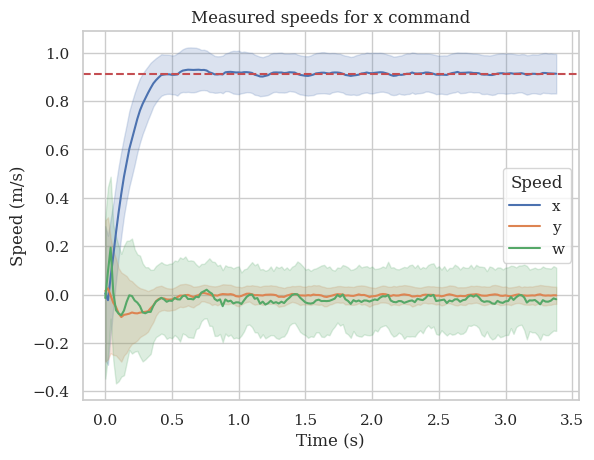

In [112]:
import numpy as np

def compute_overshoot_and_settling_time(times, speed, tolerance=0.05):
    final_value = speed[-1]
    max_value = np.max(speed)

    # Overshoot
    overshoot = ((max_value - final_value) / final_value) * 100 if final_value != 0 else 0

    # Settling time: find the first time after which speed stays within the tolerance band
    upper_bound = final_value * (1 + tolerance)
    lower_bound = final_value * (1 - tolerance)

    for i in range(len(speed)):
        if np.all((speed[i:] >= lower_bound) & (speed[i:] <= upper_bound)):
            settling_time = times[i]
            break
    else:
        settling_time = np.nan  # never settles

    return overshoot, settling_time


#Measured speed
fname = "plane-None-1-0-x"
metric = "slope" if "slope" in fname else "height"

def get_speed_xy(data, max_timesteps=500):
    y = [np.array(item[f"vel_y"][0][:max_timesteps]) for item in data]
    x = [np.array(item[f"vel_x"][0][:max_timesteps]) for item in data]
    w = [np.array(item[f"vel_w"][0][:max_timesteps]) for item in data]
    return x, y, w

with open(os.path.join(LEGGED_GYM_ROOT_DIR, 'legged_gym', 'scripts',fname+'.json'), 'r') as file:
    data = json.load(file)  # Load and parse the JSON file

speed_x, speed_y, speed_w = get_speed_xy(data)

plt.figure()
plt.title(f"Measured speeds for {fname.split('-')[-1]} command")
#plt.axhline(y=float(fname.split("-")[-3]), color='r', linestyle='--')
#plt.axhline(y=0, color='r', linestyle='--')
mean_values = plot_error_lineplots([speed_x, speed_y, speed_w], xlabel="Time (s)", ylabel="Speed (m/s)", names=["x", "y", "w"])
mean_speed, times = mean_values[mean_values["Speed"]==fname.split('-')[-1]]["Speed (m/s)"].values, mean_values[mean_values["Speed"]==fname.split('-')[-1]]["Time (s)"].values
overshoot, set_time = compute_overshoot_and_settling_time(times, mean_speed, tolerance=0.075)
print(overshoot, set_time)
plt.axhline(y=mean_speed[-1], color='r', linestyle='--')
plt.show()

In [97]:
mean_values[mean_values["Speed"]==fname.split('-')[-1]]

,Time (s),Speed,Speed (m/s)
2,0.00,y,0.014728
5,0.02,y,0.025557
8,0.04,y,0.197131
11,0.06,y,0.251808
14,0.08,y,0.279378
...,...,...,...
527,3.50,y,0.857360
530,3.52,y,0.859762
533,3.54,y,0.861866
536,3.56,y,0.859311


In [47]:
np.array(data[0]["vel_x"]).shape
data[0]["vel_x"][0]

[0.20541784167289734,
 0.18937338888645172,
 0.2727038860321045,
 0.3054160475730896,
 0.3985340893268585,
 0.5126994252204895,
 0.5632606148719788,
 0.5525429248809814,
 0.5788272023200989,
 0.661933422088623,
 0.7377718687057495,
 0.8264011144638062,
 0.8276592493057251,
 0.8416817784309387,
 0.8343386054039001,
 0.8259411454200745,
 0.7936060428619385,
 0.8380527496337891,
 0.8989923596382141,
 0.888928234577179,
 0.9069271683692932,
 0.8985210657119751,
 0.9124869704246521,
 0.926795244216919,
 0.9328649044036865,
 0.9139513373374939,
 0.8823498487472534,
 0.8647624850273132,
 0.8364046216011047,
 0.8230109214782715,
 0.8271976113319397,
 0.8411644101142883,
 0.8554260730743408,
 0.8661038279533386,
 0.8801359534263611,
 0.8475611805915833,
 0.7923170328140259,
 0.9047071933746338,
 0.9065587520599365,
 0.9122657775878906,
 0.9455687403678894,
 0.9425833821296692,
 0.9691603779792786,
 0.9314489364624023,
 0.9261921048164368,
 0.8821670413017273,
 0.8618148565292358,
 0.85169035196

/home/zetans/anaconda3/envs/rlgpu/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/zetans/anaconda3/envs/rlgpu/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/zetans/anaconda3/envs/rlgpu/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


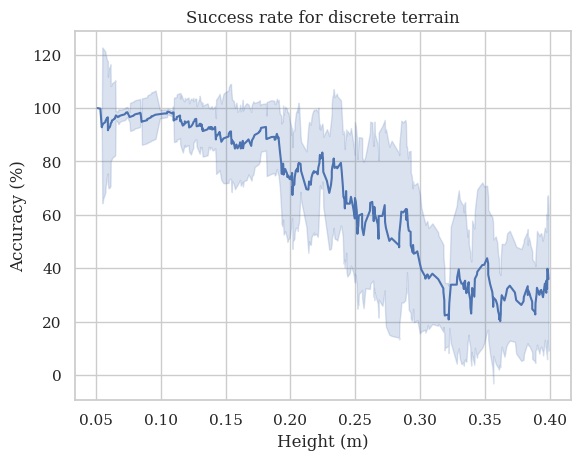

In [3]:
#Discrete
def myFunc(e):
  return e[metric]

#PATH = os.path.join(LEGGED_GYM_ROOT_DIR, 'legged_gym', 'scripts')
PATH = "/home/zetans/Desktop/results_plots/terrain_accuracy/25_limit"
fname = "discrete-None-0.75-0.075-y"
metric = "slope" if "slope" in fname else "height"
with open(os.path.join(PATH,fname+'.json'), 'r') as file:
  data = json.load(file)  # Load and parse the JSON file

data.sort(key=myFunc)
accuracy = [item["successful"]*100/item["total"] for item in data]
slope = [item[metric] for item in data]

smoothing_plot(slope, accuracy, smooth_factor=0.1)
plt.xlabel('Slope' if metric=="slope" else "Height (m)")
plt.ylabel('Accuracy (%)')
plt.title('Success rate for '+fname.split("-")[0]+' terrain')
plt.show()

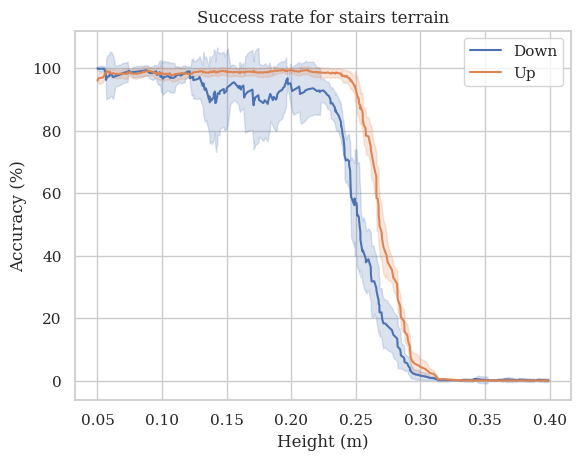

In [6]:
#Slope or stairs
def myFunc(e):
  return e[metric]

def get_x_y(path):
    with open(path, 'r') as file:
        data = json.load(file)  # Load and parse the JSON file
    data.sort(key=myFunc)
    y = np.array([item["successful"]*100/item["total"] for item in data])
    #Free memory usage
    if metric=="slope":
        x = [np.array(np.rad2deg(np.arctan(item[metric]))) for item in data]
    else:    
        x = [np.array(item[metric]) for item in data]
    return np.array(x), y

PATH = "/home/zetans/Desktop/results_plots/terrain_accuracy/80_limit"
#PATH = os.path.join(LEGGED_GYM_ROOT_DIR, 'legged_gym', 'scripts')
fname = "stairs-None-0.75-0.075-y"
metric = "slope" if "slope" in fname else "height"

x_down, y_down = get_x_y(os.path.join(PATH, fname.replace("None", "True")+'.json'))
smoothing_plot(x_down, y_down, smooth_factor=0.1, label="Down")
del x_down, y_down
x_up, y_up = get_x_y(os.path.join(PATH, fname.replace("None", "False")+'.json'))
smoothing_plot(x_up, y_up, smooth_factor=0.1, label="Up")
del x_up, y_up
plt.xlabel('Slope (°)' if metric=="slope" else "Height (m)")
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Success rate for '+fname.split("-")[0]+' terrain')
plt.show()

In [12]:
import json, os
import numpy as np
from scipy.spatial.transform import Rotation as R
fname = "init_poses_collected copy"
with open(fname+'.json', 'r') as file:
    data = json.load(file)  # Load and parse the JSON file
quaternions = data["base_orientation"]
euler_angles_list = [R.from_quat(quat).as_euler('xyz', degrees=True) for quat in quaternions]
euler_angles_list

[array([1.79999464e+02, 2.55509677e-03, 1.26528930e+02]),
 array([ 1.79999931e+02,  1.18739704e-03, -1.04016074e+02]),
 array([-1.79999953e+02,  1.51904990e-03, -1.26158198e+02]),
 array([-1.70027704e-04,  1.42521904e-03,  8.41896460e+01]),
 array([1.12842237e-04, 8.14269311e-04, 6.03943041e+01]),
 array([ -0.67734789,  25.04456733, -75.47665986]),
 array([ 2.78574216e-04,  7.83897695e-04, -5.94931913e+00]),
 array([-1.79999931e+02,  1.39361318e-03,  1.58111511e+02]),
 array([ -1.51884898, -24.14198159,  47.05317369]),
 array([  -5.11970116,  -81.60320848, -134.36765136]),
 array([ -0.18925045, -67.63502268,  36.06121897]),
 array([-1.79999981e+02,  1.64966374e-03, -3.21690430e+01]),
 array([-4.47836965e-04,  1.22163584e+01, -1.01866734e+02]),
 array([ -2.60670359, -20.02672034,  73.7623175 ]),
 array([1.79999236e+02, 2.89920297e-03, 9.48786071e+01]),
 array([-1.79999970e+02,  1.38054928e-03,  1.33744944e+01]),
 array([ 1.79999889e+02,  1.23352632e-03, -1.49360926e+02]),
 array([2.7406

Speed analsys

In [10]:
#PATH = "/home/zetans/Desktop/results_plots/speed_tracking/25limit"
PATH = os.path.join(LEGGED_GYM_ROOT_DIR, 'legged_gym', 'scripts')

In [11]:
#Slope or stairs
def myFunc(e):
  return e[metric]
def get_speed(data):
    dir = fname[-1]
    y = [item[f"vel_{dir}"] for item in data]
    x = [item["commands"] for item in data]
    #Free memory usage
    y = np.array([[np.array(y[i][j], dtype=np.float32).mean(axis=0) for j in range(np.array(y).shape[1])] for i in range(np.array(y).shape[0])], dtype=object)
    return np.array(x), y
fname = "plane-None-0.75-0-x"
metric = "slope" if "slope" in fname else "height"
down = None
with open(os.path.join(PATH,fname.replace("None", str(down))+'.json'), 'r') as file:
    data = json.load(file)  # Load and parse the JSON file
commands, speeds = get_speed(data)
del data

/home/zetans/anaconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == "__main__":


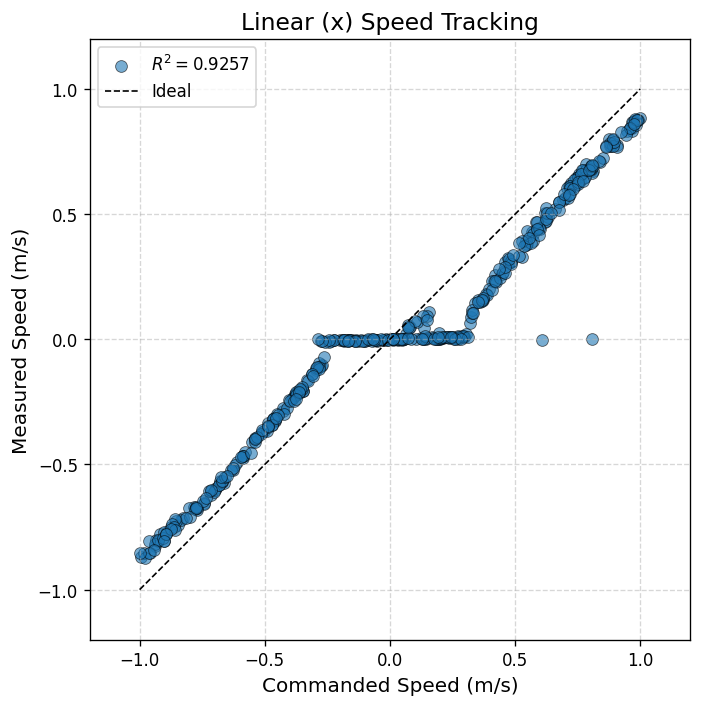

R² score: 0.9257147638132539


In [12]:
from sklearn.metrics import r2_score
idxs_dir = ["x", "y", "w"]
commanded_speed = commands[:, :, idxs_dir.index(fname[-1])][:, 0]
measured_speed = speeds[:, 0]
r2 = r2_score(commanded_speed, measured_speed)

# Scatter plot
unit = "rad/s" if idxs_dir.index(fname[-1])==2 else "m/s" 
titles =["Linear (x)", "Linear (y)", "Angular"]


# Scatter plot with styling
plt.figure(figsize=(6, 6), dpi=120)
plt.scatter(commanded_speed, measured_speed, 
            alpha=0.6, 
            edgecolor='k', 
            linewidth=0.5, 
            s=50, 
            label=f'$R^2 = {r2:.4f}$')
plt.plot([-1, 1], [-1, 1], 'k--', linewidth=1, label="Ideal")
plt.xlabel(f"Commanded Speed ({unit})", fontsize=12)
plt.ylabel(f"Measured Speed ({unit})", fontsize=12)
plt.title(f"{titles[idxs_dir.index(fname[-1])]} Speed Tracking", fontsize=14)
plt.xlim((-1.2, 1.2))
plt.ylim((-1.2, 1.2))
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()

# Print R² score
print("R² score:", r2)

Torque analysis

In [3]:
#Slope or stairs
def myFunc(e):
  return e[metric]
def get_torques(data):
    data.sort(key=myFunc)
    y = [item["torques"] for item in data]
    if metric=="slope":
        x = [np.rad2deg(np.arctan(item[metric])) for item in data]
    else:    
        x = [item[metric] for item in data]
    #Free memory usage
    y = np.array([[np.array(y[i][j], dtype=np.float32) for j in range(50)] for i in range(400)], dtype=object)
    return np.array(x), y
fname = "discrete-None-0.75-0.075-False"
metric = "slope" if "slope" in fname else "height"
down = None
with open(os.path.join(LEGGED_GYM_ROOT_DIR, 'legged_gym', 'scripts',fname.replace("None", str(down))+'.json'), 'r') as file:
    data = json.load(file)  # Load and parse the JSON file
x, torques = get_torques(data)
del data

FileNotFoundError: [Errno 2] No such file or directory: '/home/zetans/Desktop/rl_hybriped/legged_gym/legged_gym/scripts/discrete-None-0.75-0.075-False.json'

In [4]:
avg_torque = np.zeros((400, 12))

for i in range(400):  # Iterate over robots
    all_steps = np.concatenate(torques[i], axis=0)  # Flatten all 50 runs (n, 12) -> (sum(n), 12)
    avg_torque[i] = np.mean(np.abs(all_steps), axis=0)  # Compute mean per articulation

mean_per_joint = avg_torque.reshape(-1,4,3).mean(axis=1)
mean_per_leg = avg_torque.reshape(-1,4,3).mean(axis=2)

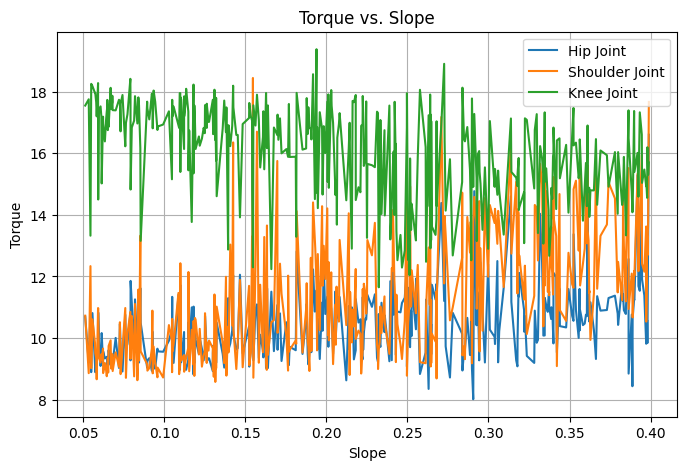

In [ ]:
# Plotting
plt.figure(figsize=(8, 5))
plt.plot(x, mean_per_joint[:, 0], label='Hip Joint')
plt.plot(x, mean_per_joint[:, 1], label='Shoulder Joint')
plt.plot(x, mean_per_joint[:, 2], label='Knee Joint')

# Labels and legend
plt.xlabel("Slope")
plt.ylabel("Torque")
plt.title("Torque vs. Slope")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

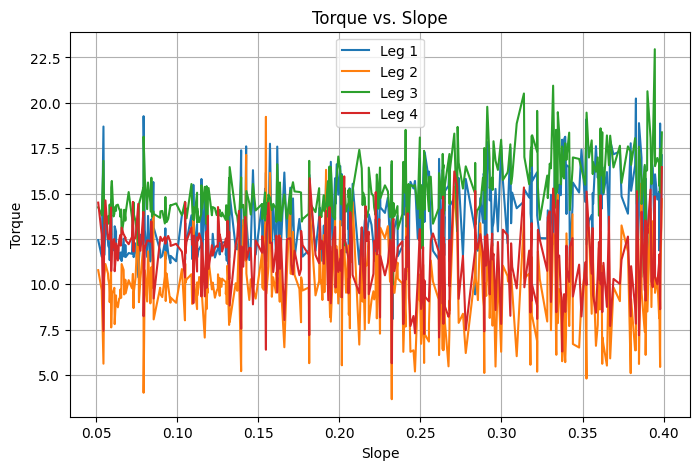

In [6]:
# Plotting
plt.figure(figsize=(8, 5))
plt.plot(x, mean_per_leg[:, 0], label='Leg 1')
plt.plot(x, mean_per_leg[:, 1], label='Leg 2')
plt.plot(x, mean_per_leg[:, 2], label='Leg 3')
plt.plot(x, mean_per_leg[:, 3], label='Leg 4')

# Labels and legend
plt.xlabel("Slope")
plt.ylabel("Torque")
plt.title("Torque vs. Slope")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

**All torque analysis - Irregular**

In [3]:
PATH = "/home/zetans/Desktop/results_plots/terrain_accuracy/25_limit"
#PATH = os.path.join(LEGGED_GYM_ROOT_DIR, 'legged_gym', 'scripts')

In [4]:
#Slope or stairs
def myFunc(e):
  return e[metric]
def get_torques(path):
    with open(path, 'r') as file:
        data = json.load(file)  # Load and parse the JSON file
    data.sort(key=myFunc)
    y = [item["torques"] for item in data]
    #Free memory usage
    std_y = np.array([[np.abs(np.array(y[i][j], dtype=np.float32)).std(axis=0) for j in range(50)] for i in range(400)], dtype=object)
    #std_y = np.array([[np.max(np.abs(np.array(y[i][j], dtype=np.float32)), axis=0) - np.min(np.abs(np.array(y[i][j], dtype=np.float32)), axis=0) for j in range(50)] for i in range(400)], dtype=object)
    y = np.array([[np.abs(np.array(y[i][j], dtype=np.float32)).mean(axis=0) for j in range(50)] for i in range(400)], dtype=object)
    return std_y, y

In [13]:
from tqdm import tqdm
#iterations_values = [("slope", True), ("slope", False), ("stairs", True), ("stairs", False), ("discrete", None)]
iterations_values = [("slope", False), ("stairs", False)]
n = 20
group_difficulties = np.zeros((len(iterations_values), n, 50, 12))
group_difficulties_std = np.zeros((len(iterations_values), n, 50, 12))
for i, (terrain, down) in tqdm(enumerate(iterations_values)):
    fname = f"{terrain}-None-0.75-0.075-y"
    metric = "slope" if "slope" in fname else "height"
    path = os.path.join(PATH,fname.replace("None", str(down))+'.json')
    torques_std, torques = get_torques(path)
    group_difficulties[i] = (torques.reshape(n, -1, torques.shape[1], torques.shape[2])).mean(axis=1)
    group_difficulties_std[i] = (torques_std.reshape(n, -1, torques.shape[1], torques.shape[2])).mean(axis=1)

2it [03:52, 116.47s/it]


In [14]:
group_difficulties_joint = (group_difficulties.reshape(group_difficulties.shape[0], group_difficulties.shape[1], group_difficulties.shape[2], 2, 2, 3)).mean(axis=(0, 4))
group_difficulties_joint_std = (group_difficulties_std.reshape(group_difficulties.shape[0], group_difficulties.shape[1], group_difficulties.shape[2], 2, 2, 3)).mean(axis=(0, 4))

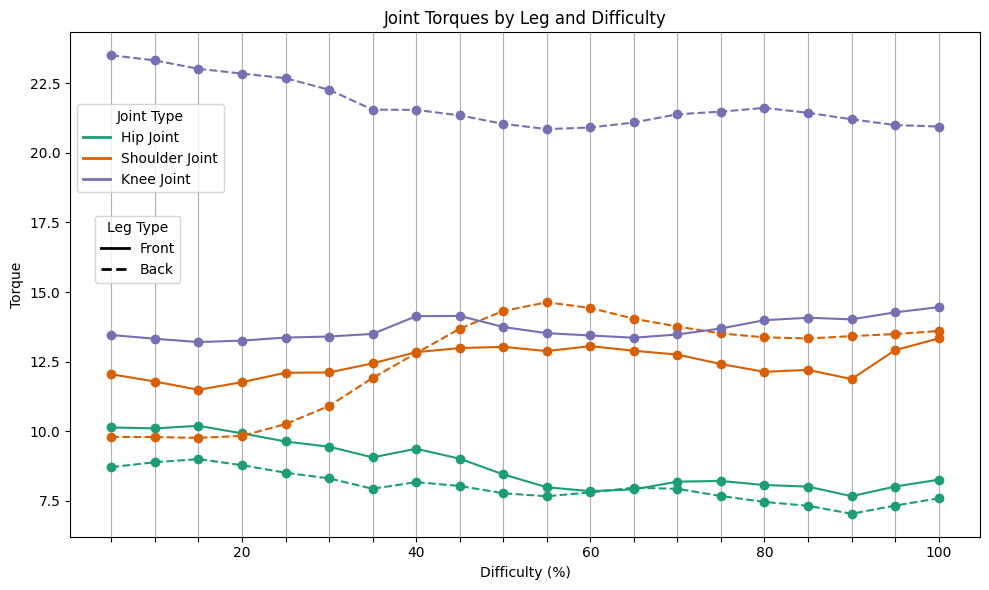

In [15]:
from matplotlib.lines import Line2D
# Compute mean and standard deviation over trials (axis=1)
mean_torque = np.mean(group_difficulties_joint, axis=1)  # Shape: (n, 2, 3)
std_torque = np.mean(group_difficulties_joint_std, axis=1)    # Shape: (n, 2, 3)

difficulties = np.arange(1, n+1)*5

motor_labels = ["Hip Joint", "Shoulder Joint", "Knee Joint"]
colors = ["#1b9e77", "#d95f02", "#7570b3"]
leg_labels = ["Front", "Back"]
line_styles = ["-", "--"]

plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot data
for joint_idx in range(3):  # joints
    for leg_idx in range(2):  # legs
        ax.errorbar(
            difficulties,
            mean_torque[:, leg_idx, joint_idx],
            # yerr=std_torque[:, leg_idx, joint_idx],
            color=colors[joint_idx],
            linestyle=line_styles[leg_idx],
            capsize=4,
            marker='o'
        )

# First legend: Joint types (color)
offset = 0.07
joint_legend = [Line2D([0], [0], color=colors[i], lw=2) for i in range(3)]
legend1 = ax.legend(joint_legend, motor_labels, title="Joint Type", loc="center left", bbox_to_anchor=(0, 0.7+offset))
ax.add_artist(legend1)

# Second legend: Leg types (line style)
leg_legend = [Line2D([0], [0], color='k', linestyle=line_styles[i], lw=2) for i in range(2)]
ax.legend(leg_legend, leg_labels, title="Leg Type", loc="center left", bbox_to_anchor=(0.02, 0.5+offset))

ax.set_xlabel("Difficulty (%)")
ax.set_ylabel("Torque")
ax.set_title("Joint Torques by Leg and Difficulty")

# Grid on all x ticks
ax.set_xticks(difficulties)  # all ticks for grid lines
ax.grid(axis="x")

# Only 5 labels
selected_ticks = [20, 40, 60, 80, 100]
ax.set_xticks(difficulties)  # keep grid lines
ax.set_xticklabels([str(tick) if tick in selected_ticks else '' for tick in difficulties])

plt.tight_layout()
plt.show()

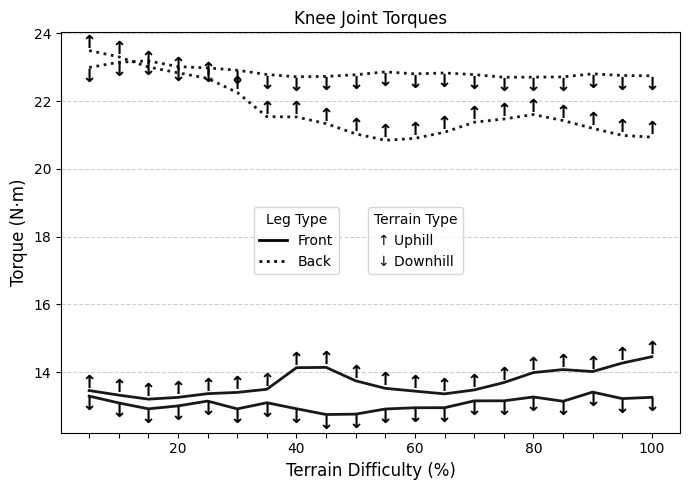

In [24]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Datos
PATH = "/home/zetans/Desktop/results_plots/torque_analysis/25_limit"

torques_up = np.load(os.path.join(PATH,'torques_up.npy'))
torques_down = np.load(os.path.join(PATH,'torques_down.npy'))
mean_torques = [torques_up, torques_down]

n = torques_up.shape[0]
difficulties = np.arange(1, n+1) * 5

# Configuración
joint_idx = 2
motor_labels = ["Hip Joint", "Shoulder Joint", "Knee Joint"]
motor_label = motor_labels[joint_idx]

# Nueva asignación:
leg_labels = ["Front", "Back"]
colors = ["#000000", "#000000"]  # Front = verde, Back = naranja
line_styles = ["-", "dotted"]
terrain_labels = ["Uphill", "Downhill"]
markers = [6, 7]  # arriba para subida, abajo para bajada

offset = 0.42
diff = 0.09
x_diff = 0.1
# Plot
fig, ax = plt.subplots(figsize=(7, 5))

for leg_idx in range(2):
    for terrain_idx in range(2):
        y = mean_torques[terrain_idx][:, leg_idx, joint_idx]
        color = colors[leg_idx]
        marker_char = '↑' if terrain_idx == 0 else '↓'

        # Plot the line
        ax.plot(
            difficulties, y,
            color=color,
            linestyle=line_styles[leg_idx],
            linewidth=2,
            alpha=0.9  # dimmed to emphasize markers
        )

        # Add arrow "markers" as text
        for x_i, y_i in zip(difficulties, y):
            a = y_i-0.03 if marker_char == '↑' else y_i
            ax.text(
                x_i, a,
                marker_char,
                fontsize=13,
                color=color,
                ha='center',
                va='bottom' if marker_char == '↑' else 'top',
                fontweight='bold'
            )


# Ejes
ax.set_xlabel("Terrain Difficulty (%)", fontsize=12)
ax.set_ylabel("Torque (N·m)", fontsize=12)

# Leyenda 1: Tipo de pata (color)
leg_legend = [
    Line2D([0], [0], linestyle=line_styles[i], lw=2, color=colors[0]) for i in range(2)
]
legend1 = ax.legend(leg_legend, leg_labels, title="Leg Type", bbox_to_anchor=(0.46, 0.58)) #loc = "center left")#
ax.add_artist(legend1)

# Leyenda 2: Tipo de terreno (flechas Unicode)
terrain_legend = [
    Line2D([0], [0], color='k', linestyle='None', marker='None', label='↑ Uphill'),
    Line2D([0], [0], color='k', linestyle='None', marker='None', label='↓ Downhill'),
]
ax.legend(
    handles=terrain_legend,
    title="Terrain Type",
    bbox_to_anchor=(0.66, 0.58),
    #loc = "center right",
    handlelength=0.05,       # reduce línea horizontal del símbolo
    handletextpad=0.1,      # espacio entre símbolo y texto
)

# Estética
ax.set_xticks(difficulties)
selected_ticks = [20, 40, 60, 80, 100]
ax.set_xticklabels([str(t) if t in selected_ticks else '' for t in difficulties])
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax.set_title(f"{motor_label} Torques")

plt.tight_layout()
plt.savefig(f"{motor_label.lower().replace(' ', '_')}_torques_plot.png", dpi=300)
plt.show()


In [14]:
data = {
    "difficulties": difficulties.tolist(),
    "torque_data": []
}
for i in range(3):
    motor_data = {
        "motor": motor_labels[i],
        "mean_torque": mean_torque[:, :, i].tolist(),
        "std_torque": std_torque[:, :, i].tolist()
    }
    data["torque_data"].append(motor_data)

# Write to JSON file
with open("torqueVSdifficulty_data_discrete.json", "w") as f:
    json.dump(data, f, indent=4)

**All torque analysis - Flat terrain**

In [3]:
#PATH = "/home/zetans/Desktop/results_plots/speed_tracking"
PATH = "/home/zetans/Desktop/results_plots/speed_tracking/25limit"

In [4]:
def myFunc(e):
  return np.array(np.abs(e[metric])).mean()
  #return e["commands"][0][0]
def get_torques(path):
    with open(path, 'r') as file:
        data = json.load(file)  # Load and parse the JSON file
    data.sort(key=myFunc)
    y = [item["torques"] for item in data]
    #Free memory usage
    std_y = np.array([np.squeeze(np.abs(np.array(y[i], dtype=np.float32))).std(axis=0) for i in range(400)], dtype=object)
    #std_y = np.array([[np.max(np.abs(np.array(y[i][j], dtype=np.float32)), axis=0) - np.min(np.abs(np.array(y[i][j], dtype=np.float32)), axis=0) for j in range(50)] for i in range(400)], dtype=object)
    y = np.array([np.squeeze(np.abs(np.array(y[i], dtype=np.float32))).mean(axis=0) for i in range(400)], dtype=object)
    return std_y, y

In [5]:
from tqdm import tqdm
iterations_values = ["x", "y", "w"]
n = 20
group_speeds = np.zeros((len(iterations_values), n, 12))
group_speeds_std = np.zeros((len(iterations_values), n, 12))
for i, (direction) in tqdm(enumerate(iterations_values)):
    fname = f"plane-None-0.75-0.075-{direction}"
    metric = f"vel_{direction}"
    path = os.path.join(PATH,fname+'.json')
    torques_std, torques = get_torques(path)
    group_speeds[i] = (torques.reshape(n, -1, torques.shape[1])).mean(axis=1)
    group_speeds_std[i] = (torques_std.reshape(n, -1, torques.shape[1])).mean(axis=1)

3it [00:09,  3.12s/it]


In [6]:
group_speeds_joint = (group_speeds.reshape(group_speeds.shape[0], group_speeds.shape[1], 4, 3)).mean(axis=(0, 2))
group_speeds_joint_std = (group_speeds_std.reshape(group_speeds.shape[0], group_speeds.shape[1], 4, 3)).mean(axis=(0, 2))

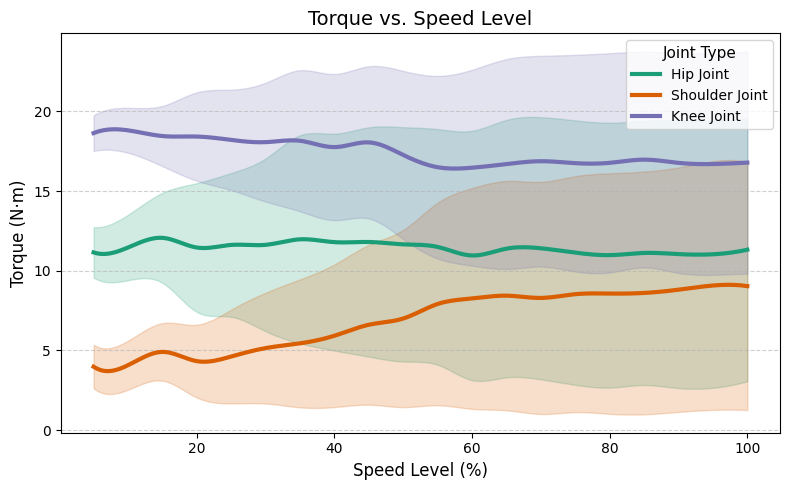

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# X-axis: Terrain difficulties (Speed levels in %)
difficulties = np.arange(1, n + 1) * 5

# Joint labels and grayscale-printable colors
motor_labels = ["Hip Joint", "Shoulder Joint", "Knee Joint"]
colors = ["#1b9e77", "#d95f02", "#7570b3"]

# Interpolated X-axis (dense for smooth curve)
x_smooth = np.linspace(difficulties.min(), difficulties.max(), 200)

# Plot setup
fig, ax = plt.subplots(figsize=(8, 5))

# Plot for each joint
for i in range(3):
    y_mean = group_speeds_joint[:, i]
    y_std  = group_speeds_joint_std[:, i]

    # Interpolation for mean and std
    mean_spline = make_interp_spline(difficulties, y_mean, k=3)
    std_spline  = make_interp_spline(difficulties, y_std, k=3)
    y_smooth = mean_spline(x_smooth)
    std_smooth = std_spline(x_smooth)

    # Plot mean curve
    ax.plot(
        x_smooth,
        y_smooth,
        label=motor_labels[i],
        color=colors[i],
        linewidth=3
    )

    # Plot shaded area for ±std
    ax.fill_between(
        x_smooth,
        y_smooth - std_smooth,
        y_smooth + std_smooth,
        alpha=0.2,
        color=colors[i]
    )

# Axis labels and title
ax.set_xlabel("Speed Level (%)", fontsize=12)
ax.set_ylabel("Torque (N·m)", fontsize=12)
ax.set_title("Torque vs. Speed Level", fontsize=14)

# Legend
ax.legend(title="Joint Type", fontsize=10, title_fontsize=11)

# X-ticks and grid
#ax.set_xticks(difficulties)
#selected_ticks = [20, 40, 60, 80, 100]
#ax.set_xticklabels([str(t) if t in selected_ticks else '' for t in difficulties])
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

# Layout and show
plt.tight_layout()
plt.show()


In [37]:
data = {
    "speeds": difficulties.tolist(),
    "torque_data": []
}
for i in range(3):
    motor_data = {
        "motor": motor_labels[i],
        "mean_torque": group_speeds_joint[:, i].tolist(),
        "std_torque": group_speeds_joint_std[:, i].tolist()
    }
    data["torque_data"].append(motor_data)

# Write to JSON file
with open("torqueVSspeed_data.json", "w") as f:
    json.dump(data, f, indent=4)

Torque analysis fall recovery

In [8]:
#PATH = os.path.join(LEGGED_GYM_ROOT_DIR, 'legged_gym', 'scripts')
PATH = "/home/zetans/Desktop/results_plots/torque_analysis/25_limit"
path = os.path.join(PATH,'torques_recovery.json')
with open(path, 'r') as file:
    torques_recovery = json.load(file)[:-1]  # Load and parse the JSON file

In [9]:
data_np = np.array([np.abs(np.array(torques_recovery[i], dtype=object)) for i in range(len(torques_recovery))], dtype=object)


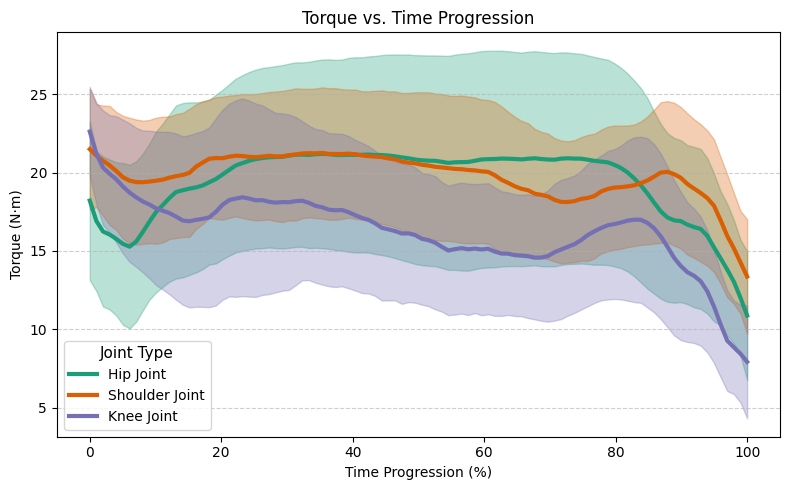

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure each trial is a NumPy array
data = np.array([np.array(trial) for trial in data_np], dtype=object)

# Joint mapping: 4 legs × 3 joints = 12 joints
joint_labels = motor_labels
joint_indices = {
    joint_labels[0]: [0, 3, 6, 9],
    joint_labels[1]: [1, 4, 7, 10],
    joint_labels[2]: [2, 5, 8, 11]
}

# Normalize all to 100 time steps (percentage)
n_interp = 100
x_target = np.linspace(0, 1, n_interp)

interpolated = {jt: [] for jt in joint_labels}

for trial in data:
    t_len = trial.shape[0]
    x_original = np.linspace(0, 1, t_len)

    for jt in joint_labels:
        indices = joint_indices[jt]
        torque = np.array(trial[:, indices].mean(axis=1), dtype="float64")  # average across joints A/B/C
        torque_interp = np.interp(x_target, x_original, torque)
        interpolated[jt].append(torque_interp)

# Convert to stacked NumPy arrays
mean_curves = {jt: np.mean(np.stack(interpolated[jt]), axis=0) for jt in joint_labels}
std_curves  = {jt: np.std(np.stack(interpolated[jt]), axis=0) for jt in joint_labels}

# Plot all three on the same figure
colors = {joint_labels[0]: '#1b9e77', joint_labels[1]: '#d95f02', joint_labels[2]: '#7570b3'}
plt.figure(figsize=(8, 5))
x_plot = x_target * 100  # percentage

for jt in joint_labels:
    plt.plot(x_plot, mean_curves[jt], label=f"{jt}", color=colors[jt], linewidth=3)
    plt.fill_between(x_plot,
                     mean_curves[jt] - std_curves[jt],
                     mean_curves[jt] + std_curves[jt],
                     alpha=0.3,
                     color=colors[jt])

plt.xlabel("Time Progression (%)")
plt.ylabel("Torque (N·m)")
plt.title("Torque vs. Time Progression")
plt.legend(title="Joint Type", fontsize=10, title_fontsize=11, loc="lower left")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [239]:
#Compute mean torque per joint
torque_sums = {joint_labels[0]: 0.0, joint_labels[1]: 0.0, joint_labels[2]: 0.0}
counts = {joint_labels[0]: 0, joint_labels[1]: 0, joint_labels[2]: 0}

# Sum all values per joint type
for trial in data:
    for jt in [joint_labels[0], joint_labels[1], joint_labels[2]]:
        values = trial[:, joint_indices[jt]]  # shape: (n_i, 4)
        torque_sums[jt] += np.sum(values)
        counts[jt] += np.prod(values.shape)

# Compute means
mean_torque_per_joint_type = {jt: torque_sums[jt] / counts[jt] for jt in torque_sums}

In [259]:
# Write to JSON file
with open("torqueRecovery_data.json", "w") as f:
    json.dump(mean_torque_per_joint_type, f, indent=4)

**CURRENT ANALYSIS**

In [5]:
import os
PATH = "/home/zetans/Desktop/results_plots/torque_analysis/25_limit"
RED_FACTOR_KNEE = 0.808/1.89
TOTAL_I_WHEELS = 1.19*4/0.37
JETSON_CURRENT = 2
OTHER_ELECT_CURRENT = 1
OPERATING_VOLTAGE = 48
VOLTAGES = {"joints": 48, "wheels": 24, "jetson": 19, "electro": 5}

def T2I(torque):
    #Convert torque to current, acording to motor curve
    return 0.2857*torque+0.2

def get_pond_current(I_data):
    total_current = {"joints": 0, "wheels": TOTAL_I_WHEELS, "jetson": JETSON_CURRENT, "electro": OTHER_ELECT_CURRENT}
    for k, v in I_data.items():
        total_current["joints"] += np.array(v).mean()
    total_current["joints"] *= 4
    pond_current = 0
    for k, v in total_current.items():
        pond_current += VOLTAGES[k]*v
    pond_current /= OPERATING_VOLTAGE
    return pond_current

FLAT TERRAIN

In [6]:
path = os.path.join(PATH, "torqueVSspeed_data.json")
with open(path, 'r') as file:
    data = json.load(file)  # Load and parse the JSON file

In [7]:
I_data_flat = {}
for motor_data in data["torque_data"]:
    motor_name = motor_data["motor"]
    if motor_name == "Knee Joint":
        I_data_flat[motor_name] = [T2I(i)*RED_FACTOR_KNEE for i in motor_data["mean_torque"]]
    else:
        I_data_flat[motor_name] = [T2I(i) for i in motor_data["mean_torque"]]

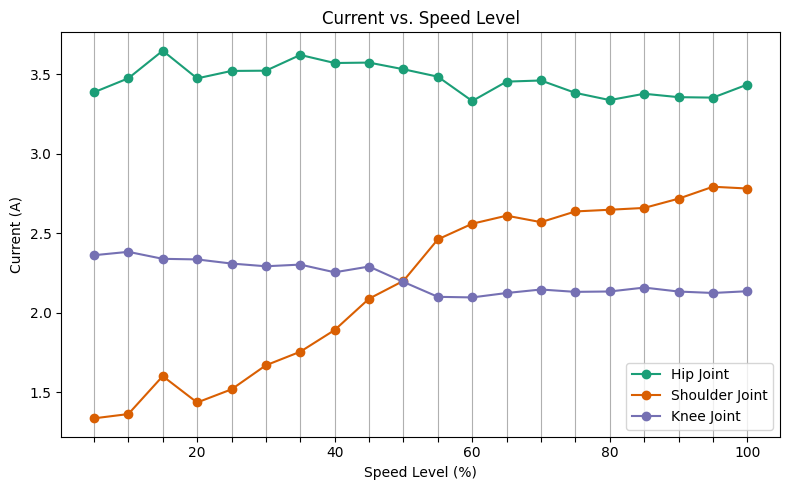

In [8]:
# Terrain difficulties (X-axis values)
n=20
difficulties = np.arange(1, n+1) * 5

# Elegant grayscale-friendly colors for paper
colors = ["#1b9e77", "#d95f02", "#7570b3"]
motor_labels = list(I_data_flat.keys())

# Plot setup
plt.figure(figsize=(8, 5))
ax = plt.gca()

# Plot lines
for i, label in enumerate(motor_labels):
    ax.errorbar(
        difficulties,
        I_data_flat[label],
        label=label,
        color=colors[i],
        capsize=4,
        marker='o'
    )

# Axis labels and title
ax.set_xlabel("Speed Level (%)")
ax.set_ylabel("Current (A)")
ax.set_title("Current vs. Speed Level")

# Legend
ax.legend()

# Grid on all x ticks
ax.set_xticks(difficulties)

# Show only selected tick labels
selected_ticks = [20, 40, 60, 80, 100]
ax.set_xticklabels([str(tick) if tick in selected_ticks else '' for tick in difficulties])

# Grid
ax.grid(axis="x")

plt.tight_layout()
plt.show()

In [9]:
print("Corriente ponderada: ", str(round(get_pond_current(I_data_flat),2))+" A")

Corriente ponderada:  38.72 A


Recovery

In [10]:
path = os.path.join(PATH, "torques_recovery_mean.json")
with open(path, 'r') as file:
    data = json.load(file)  # Load and parse the JSON file

In [11]:
I_data_recov = {}
for motor_name, motor_data in data.items():
    if motor_name == "Knee Joint":
        I_data_recov[motor_name] = T2I(motor_data)*RED_FACTOR_KNEE
    else:
        I_data_recov[motor_name] = T2I(motor_data)

In [12]:
def get_pond_current_recov(I_data_recov):
    total_current = {"joints": 0, "wheels": TOTAL_I_WHEELS, "jetson": JETSON_CURRENT, "electro": OTHER_ELECT_CURRENT}
    for k, v in I_data_recov.items():
        total_current["joints"] += v
    total_current["joints"] *= 4
    pond_current = 0
    for k, v in total_current.items():
        pond_current += VOLTAGES[k]*v
    pond_current /= OPERATING_VOLTAGE
    return pond_current
print("Corriente ponderada: ", str(round(get_pond_current_recov(I_data_recov),2))+" A")

Corriente ponderada:  62.27 A


IRREGULAR TERRAIN

Discrete

In [13]:
path = os.path.join(PATH, "torqueVSdifficulty_data_discrete.json")
with open(path, 'r') as file:
    data = json.load(file)  # Load and parse the JSON file

In [14]:
I_data_disc = {}
for motor_data in data["torque_data"]:
    motor_name = motor_data["motor"]
    if motor_name == "Knee Joint":
        I_data_disc[motor_name] = [T2I(np.array(i).mean())*RED_FACTOR_KNEE for i in motor_data["mean_torque"]]
    else:
        I_data_disc[motor_name] = [T2I(np.array(i).mean()) for i in motor_data["mean_torque"]]

In [15]:
print("Corriente ponderada: ", str(round(get_pond_current(I_data_disc),2))+" A")

Corriente ponderada:  42.7 A


Stairs or slopes

In [16]:
path_up = os.path.join(PATH, "torqueVSdifficulty_data_up.json")
path_down = os.path.join(PATH, "torqueVSdifficulty_data_down.json")

with open(path_up, 'r') as file:
    data_up = json.load(file)  # Load and parse the JSON file
with open(path_down, 'r') as file:
    data_down = json.load(file)  # Load and parse the JSON file

In [17]:
I_data_elev = {}
for motor_data_up, motor_data_down in zip(data_up["torque_data"], data_down["torque_data"]):
    motor_name = motor_data_up["motor"]
    if motor_name == "Knee Joint":
        I_data_elev[motor_name] = [T2I((np.array(u).mean()+np.array(d).mean())/2.0)*RED_FACTOR_KNEE for u, d in zip(motor_data_up["mean_torque"], motor_data_down["mean_torque"])]
    else:
        I_data_elev[motor_name] = [T2I((np.array(u).mean()+np.array(d).mean())/2.0) for u, d in zip(motor_data_up["mean_torque"], motor_data_down["mean_torque"])]

In [18]:
print("Corriente ponderada: ", str(round(get_pond_current(I_data_elev),2))+" A")

Corriente ponderada:  42.32 A


Time calculation

In [21]:
times = {"elevation": 0.35, "discrete": 0.4, "flat": 0.15, "static": 0.09, "recov": 0.01}
pond_currents = {"elevation": get_pond_current(I_data_elev), "discrete": get_pond_current(I_data_disc), "flat": get_pond_current(I_data_flat), "static": 34.7283, "recov": get_pond_current_recov(I_data_recov)}
CAPACITY = 30

curr_total = 0
for k, v in times.items():
    curr_total += times[k]*pond_currents[k]

print("Duration aprox: ", str(round(CAPACITY*60/curr_total,2))+" min")

Duration aprox:  43.43 min
